### PLACE ALL IMPORTS HERE (easier to keep track of)

In [2]:
# general
from __future__ import division
from collections import defaultdict
from collections import Counter
import os
import random
import re

# to read in JSON character objects 
import json

# for stopwords
import nltk
from nltk.tokenize import RegexpTokenizer

# for LDA topic modeling
from gensim import corpora, models, similarities, matutils

# for lots of math junk and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# for making data frames
import pandas as pd
# for clustering, etc.
from sklearn import metrics
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

from scipy.cluster.hierarchy import ward, dendrogram
import scipy.stats as stats


# Read in character JSON, build feature vectors for a BOW-type model

Things to do: Fiddle with the mention threshold, dialogue features (to include or not to include?), maybe throw out the most common attributes afterward

**NOTE: All of this functionality is now located in the loadCharFeatures module**

getCharVectorsFromJson takes the following args:
    - mention_threshold (defaults to 100)
    - use_stopwords (defaults to true)
    - book_src_dir (pass in path to the raw book text)
    - json_filename (pass in path to the booknlp json file output)

In [3]:
import loadCharFeatures
reload(loadCharFeatures)
(characters, character_namelists, total_features, top_n) = loadCharFeatures.getCharVectorsFromJson(use_stopwords = True, 
                                                                                                   mention_threshold = 40)

Most common words in book:  [('the', 47552.0), ('to', 26268.0), ('and', 25179.0), ('of', 21444.0), ('a', 19852.0), ('.', 17618.0), ('was', 15155.0), ('he', 14435.0), ('his', 13612.0), ('said', 12682.0), ('in', 11952.0), ('Harry', 11326.0), ('had', 9954.0), ('that', 8840.0), ('at', 8322.0), ('you', 8044.0), ('it', 7310.0), ('I', 7282.0), ('as', 7026.0), ('with', 6272.0), ('on', 6097.0), ('for', 5193.0), ('He', 4990.0), ('not', 4666.0), ('\xc2\x91', 4527.0), ('her', 4418.0), ('they', 4259.0), ('be', 4258.0), ('were', 4155.0), ('but', 4010.0), ('from', 3997.0), ('have', 3970.0), ('out', 3847.0), ('him', 3806.0), ('\xe2\x80\x94', 3561.0), ('she', 3462.0), ('up', 3432.0), ('into', 3427.0), ('Ron', 3366.0), ('all', 3336.0), ('The', 3250.0), ('been', 3136.0), ('Hermione', 3119.0), ('what', 2798.0), ('could', 2668.0), ('back', 2595.0), ('who', 2581.0), ('their', 2497.0), ('is', 2491.0), ('them', 2482.0), ('Harry,', 2400.0), ('\xe2\x80\x9cI', 2326.0), ('looked', 2321.0), ('about', 2282.0), ('so

**Create texts to feed to gensim, print out BOW for each character**

In [4]:
texts = [None for key in characters]
names = {}
i = 0
for key, value in characters.iteritems():
    print str(key) + ": " + str(value)
    texts[i] = value
    names[key] = i
    i += 1
    print
print len(characters)

Fang: [u'take_PATIENT', u'swept_PATIENT', u'bless_PATIENT', u'take_PATIENT', u'fend_PATIENT', u'leav_PATIENT', u'carri_PATIENT', u'push_PATIENT', u'bowl_PATIENT', u'stroke_PATIENT', u'found_PATIENT', u'want_PATIENT', u'transfix_PATIENT', u'start_AGENT', u'bound_AGENT', u'yelp_AGENT', u'kept_AGENT', u'whimper_AGENT', u'fight_AGENT', u'thud_AGENT', u'howl_AGENT', u'howl_AGENT', u'fling_himself_AGENT', u'trembl_AGENT', u'ter_AGENT', u'shove_i_AGENT', u'lollop_AGENT', u'gallop_AGENT', u'save__AGENT', u'move_AGENT', u'reach_edg_AGENT', u'stop_AGENT', u'feel_chil_AGENT', u'control_own_AGENT', u'breath_AGENT', u'cling_AGENT', u'pull_it_AGENT', u'stare_AGENT', u'want_tim_AGENT', u'press_met_AGENT', u'lower_hand_AGENT', u'whimper_AGENT', u'won_AGENT', u'scratch_whin_AGENT', u'bark_AGENT', u'launch_himself_AGENT', u'trot_AGENT', u'bound_AGENT', u'strode_AGENT', u'give_bark_AGENT', u'jump_AGENT', u'lay_head_AGENT', u'come_pad_AGENT', u'howl_AGENT', u'keep_AGENT', u'dance_al_AGENT', u'take_gulp_AG

**Print most common features (to do: maybe filter these out of the model?)**

In [5]:
counter = Counter(total_features)
top_n = counter.most_common(30)
print top_n
print

# remove these words from the texts before doing topic modeling
for text in texts:
    for word_tupe in top_n:
        while word_tupe[0] in text:
            text.remove(word_tupe[0])
#print texts

[(u'wand_POSS', 944.0), (u'want_AGENT', 442.0), (u'want_SAY', 415.0), (u'turn_AGENT', 410.0), (u'right_SAY', 403.0), (u'oh_SAY', 395.0), (u'yes_SAY', 357.0), (u'tri_AGENT', 342.0), (u'stare_AGENT', 332.0), (u'yeah_SAY', 308.0), (u'potter_SAY', 294.0), (u'time_SAY', 287.0), (u'good_SAY', 267.0), (u'shoulder_POSS', 265.0), (u'tell__AGENT', 255.0), (u'stood_AGENT', 253.0), (u'walk_AGENT', 250.0), (u'whi_SAY', 248.0), (u'sat_AGENT', 247.0), (u'robe_POSS', 244.0), (u'realli_SAY', 231.0), (u'tri_SAY', 229.0), (u'hair_POSS', 219.0), (u'never_SAY', 217.0), (u'mean_SAY', 216.0), (u'voldemort_SAY', 212.0), (u'thing_SAY', 211.0), (u'ear_POSS', 210.0), (u'cours_SAY', 204.0), (u'heard_AGENT', 203.0)]



## Do LDA/HDP Topic Modeling Using Character Features

In [6]:
# create Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

# create bag of words model to perform analysis
corpus = [dictionary.doc2bow(text) for text in texts]

hdp = False

if(hdp):
    # hdp topic modeling
    hdp = models.HdpModel(corpus, id2word=dictionary)
    topics = hdp.print_topics(topics=-1, topn=20)
    numtopics = len(topics)
    print numtopics
else:
    # lda topic modeling
    numtopics = 25
    lda = models.LdaModel(corpus, num_topics=numtopics, 
                                id2word=dictionary, 
                                update_every=5, 
                                chunksize=100, 
                                passes=100)

The following commented code is an attempt to determine the optimal number of clusters using the Arun, et al. measure. Implementation credit goes to Christopher Grainger (http://blog.cigrainger.com/2014/07/lda-number.html). However, we are not using it at this time because it takes too long/too much memory to run and doesn't necessarily produce useful results.

In [7]:
# Define KL function
# def sym_kl(p,q):
#     return np.sum([stats.entropy(p,q),stats.entropy(q,p)])

# l = np.array([sum(cnt for _, cnt in doc) for doc in corpus])
# def arun(corpus,dictionary,min_topics=1,max_topics=50,step=3):
#     kl = []
#     for i in range(min_topics,max_topics,step):
#         print i
#         lda = models.LdaModel(corpus=corpus,
#             id2word=dictionary,num_topics=i,passes=20)
#         m1 = lda.expElogbeta
#         U,cm1,V = np.linalg.svd(m1)
#         #Document-topic matrix
#         lda_topics = lda[corpus]
#         m2 = matutils.corpus2dense(lda_topics, lda.num_topics).transpose()
#         cm2 = l.dot(m2)
#         cm2 = cm2 + 0.0001
#         cm2norm = np.linalg.norm(l)
#         cm2 = cm2/cm2norm
#         kl.append(sym_kl(cm1,cm2))
#     return kl
    
# kl = arun(corpus,dictionary)
# # Plot kl divergence against number of topics
# plt.plot(kl)
# plt.ylabel('Symmetric KL Divergence')
# plt.xlabel('Number of Topics')
# plt.savefig('kldiv.png', bbox_inches='tight')

In [8]:
#hdp.show_topics(topics=-1, topn=20, log=False, formatted=True)
# for topic in topics:
#     print topic
#     print

def hdpToLDA(hdpModel):
    lda = models.LdaModel(id2word=hdpModel.id2word, 
    num_topics=numtopics, eta=hdpModel.m_eta) 
    return lda

if hdp:
    lda = hdpToLDA(hdp)
print(lda.show_topics())

[u'0.012*growl_PATIENT + 0.010*growl_AGENT + 0.006*cloak_POSS + 0.005*flask_POSS + 0.005*offic_POSS + 0.004*say_what_AGENT + 0.003*curs_SAY + 0.003*need_SAY + 0.003*death_SAY + 0.003*dark_SAY', u'0.007*mother_POSS + 0.005*gang_POSS + 0.004*lip_POSS + 0.004*tongu_POSS + 0.003*father_POSS + 0.003*son_POSS + 0.003*parent_POSS + 0.002*pull_PATIENT + 0.002*friend_POSS + 0.002*ask__AGENT', u'0.005*daddi_SAY + 0.004*scream_AGENT + 0.004*pull_PATIENT + 0.003*father_POSS + 0.003*snap_AGENT + 0.003*snorkack_SAY + 0.002*rope_POSS + 0.002*drag_PATIENT + 0.002*take_PATIENT + 0.002*start_AGENT', u'0.006*escap_AGENT + 0.005*godfath_POSS + 0.005*mother_POSS + 0.004*snape_SAY + 0.004*crouch_SAY + 0.004*letter_POSS + 0.003*gone_AGENT + 0.003*parent_POSS + 0.003*kill_SAY + 0.003*sirius_SAY', u'0.003*doe_SAY + 0.003*smile_AGENT + 0.003*need_SAY + 0.003*make_SAY + 0.003*magic_SAY + 0.003*ad_AGENT + 0.003*becaus_SAY + 0.003*sure_SAY + 0.003*hagrid_SAY + 0.003*take_SAY', u'0.006*roar_PATIENT + 0.005*car_POSS

#### Print top n words for each topic

Word Clouds for each topic generated using the wordcloud package - use "pip install wordcloud" (http://peekaboo-vision.blogspot.de/2012/11/a-wordcloud-in-python.html)

Topic  0
bit_SAY ask__AGENT ad_AGENT malfoy_SAY someth_SAY pocket_POSS d'you_SAY start_AGENT snape_SAY reckon_SAY kreacher_SAY sit_AGENT becaus_SAY take_SAY master_SAY much_SAY doe_SAY bed_POSS stand_AGENT hagrid_SAY okay_SAY first_SAY onli_SAY magic_SAY ani_SAY fred_SAY turn_SAY someon_SAY make_SAY kept_AGENT 


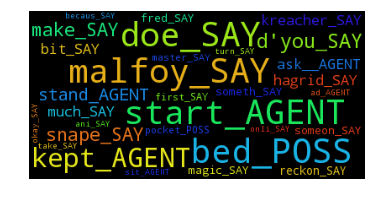

0
Topic  1
becaus_SAY sit_AGENT someth_SAY ze_SAY sister_POSS year_SAY doe_SAY ave_SAY ad_AGENT stand_AGENT tonk_SAY stay_AGENT find_SAY onli_SAY help_PATIENT tell_i_AGENT continu_AGENT mother_POSS mum_SAY give_SAY last_SAY fred_SAY chair_POSS point_AGENT take_SAY move_AGENT arri_SAY bill_SAY pleas_SAY stop_AGENT 


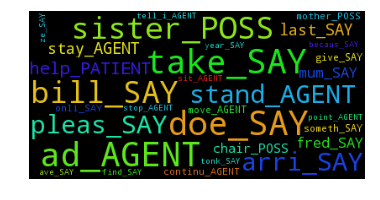

1
Topic  2
roar_PATIENT car_POSS mustach_POSS boy_SAY snarl_AGENT hous_SAY petunia_SAY bark_PATIENT vernon_SAY growl_AGENT glare_AGENT dear_SAY glass_POSS hous_POSS marg_SAY chair_POSS leav_PATIENT magic_SAY fist_POSS suit_POSS dementor_SAY room_POSS onli_SAY howev_SAY tea_SAY start_AGENT take__AGENT newspap_POSS say_what_AGENT away_SAY 


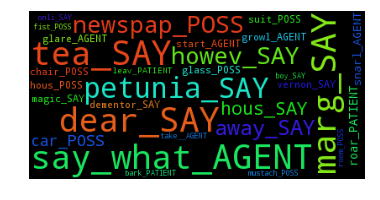

2
Topic  3
son_POSS dear_SAY arthur_SAY mum_SAY father_SAY snigger_AGENT husband_POSS take_SAY better_SAY anyon_SAY befor_SAY ad_AGENT follow_PATIENT bit_SAY work_SAY call_AGENT appear_AGENT worri_SAY laugh_AGENT suppos_SAY lip_POSS pocket_POSS sob_AGENT give_SAY littl_SAY bet_SAY ani_SAY onli_SAY last_SAY night_SAY 


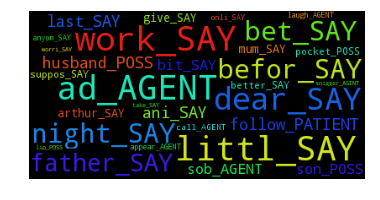

3
Topic  4
desk_POSS grandmoth_POSS follow_PATIENT offic_POSS tell_they_AGENT glass_POSS strode_AGENT parent_POSS pleas_SAY toad_POSS great_SAY move_AGENT hurri_AGENT gryffindor_SAY student_SAY appear_AGENT chest_POSS spectacl_POSS eyebrow_POSS boy_SAY call_AGENT badg_POSS sit_AGENT gran_SAY first_SAY fell_AGENT someth_SAY hous_SAY mother_POSS nod_AGENT 


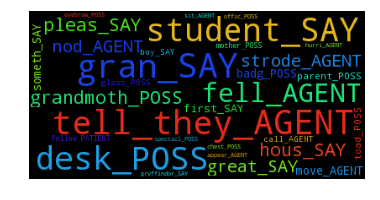

4
Topic  5
hollow_POSS hollow_POSS hollow_POSS hollow_POSS hollow_POSS hollow_POSS heir_POSS wife_POSS monster_POSS sword_SAY beat_PATIENT repres_PATIENT wish_AGENT son_POSS save_PATIENT help_SAY tell_i_AGENT hous_POSS work_POSS kill_PATIENT onli_SAY gryffindor_SAY malfoy_SAY daughter_POSS tell_w_AGENT lose_AGENT name_PATIENT overtak_PATIENT help_you_AGENT descend_POSS yard_POSS sausag_SAY hear_rumor_AGENT test_POSS have_right_AGENT 


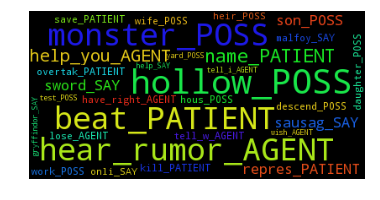

5
Topic  6
parti_POSS littl_SAY desk_POSS offic_POSS move_AGENT howl_AGENT mustach_POSS felix_SAY find_PATIENT potion_SAY stand_AGENT abl_MOD albus_SAY pocket_POSS persuad_PATIENT two_SAY turban_POSS bark_POSS take_SAY house-elf_POSS felici_SAY keep_PATIENT hard_SAY heel_POSS belli_POSS muggl_SAY live_SAY memori_POSS favorit_POSS return_AGENT 


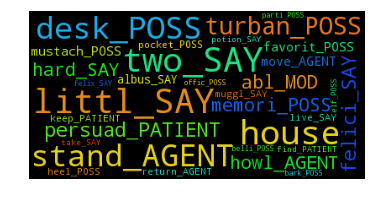

6
Topic  7
escap_AGENT godfath_POSS mother_POSS snape_SAY crouch_SAY letter_POSS gone_AGENT parent_POSS kill_SAY sirius_SAY grin_AGENT help_PATIENT innoc_MOD roar_PATIENT mother_SAY caught_PATIENT friend_SAY group_SAY dead_MOD death_POSS old_SAY feel_AGENT cauldron_POSS mirror_POSS hermi_SAY diggori_SAY trunk_POSS die_AGENT becaus_SAY near_SAY 


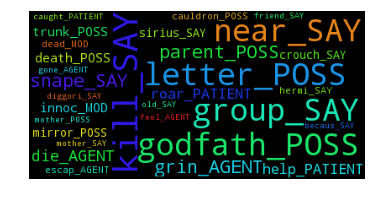

7
Topic  8
doe_SAY smile_AGENT need_SAY make_SAY magic_SAY ad_AGENT becaus_SAY sure_SAY hagrid_SAY take_SAY onli_SAY school_SAY ministri_SAY year_SAY someth_SAY bag_POSS might_SAY way_SAY ani_SAY dark_SAY peopl_SAY death_SAY happen_SAY continu_AGENT wizard_SAY sirius_SAY find_SAY offic_POSS quit_SAY pleas_SAY 


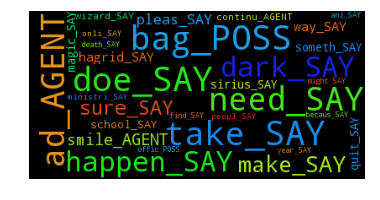

8
Topic  9
mother_POSS gang_POSS lip_POSS tongu_POSS father_POSS son_POSS parent_POSS pull_PATIENT friend_POSS ask__AGENT class_POSS hit_PATIENT note_POSS heart_POSS took_PATIENT life_POSS chair_POSS shut_SAY take_SAY help_SAY night_SAY shall_SAY finish_AGENT watch_PATIENT bag_POSS pocket_POSS dobbi_SAY big_SAY dad_SAY soul_POSS 


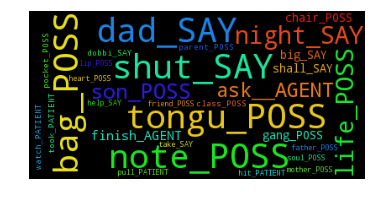

9
Topic  10
year_SAY make_SAY set_AGENT crouch_SAY room_POSS perci_SAY follow_AGENT bedroom_POSS ear_SAY ad_PATIENT refere_SAY yet_SAY watch_PATIENT bad_SAY fudg_SAY mum_SAY becaus_SAY keep_SAY old_SAY stand_AGENT take_SAY hit_PATIENT pocket_POSS boy_SAY dad_SAY sit_AGENT feel_SAY anyon_SAY sort_SAY room_SAY 


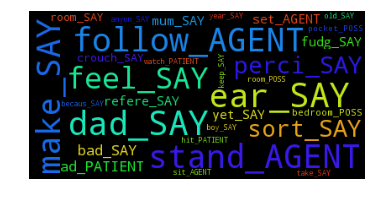

10
Topic  11
book_POSS offic_POSS dear_SAY friend_POSS portrait_POSS sure_SAY desk_POSS trunk_POSS taken_SAY return_AGENT weasley_SAY blame_PATIENT mr._SAY book_SAY frame_POSS call_AGENT talk_AGENT last_SAY side_POSS appear_AGENT snape_SAY offic_SAY ah_SAY stop_AGENT father_POSS sister_POSS memori_POSS brother_POSS er_SAY watch_PATIENT 


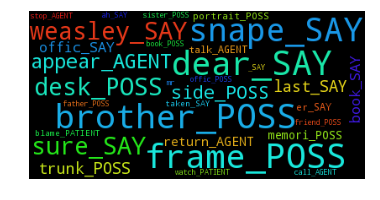

11
Topic  12
die_AGENT montagu_SAY weasley_SAY kill_PATIENT slytherin_SAY bell_SAY wand_SAY quaffl_SAY bludger_SAY sit_AGENT keep_SAY take_SAY move_AGENT pass_SAY death_POSS spinnet_SAY drop_SAY watch_PATIENT parent_POSS fine_SAY emerg_AGENT possess_SAY gryffindor_SAY stand_AGENT much_SAY thank_SAY shake_head_AGENT air_SAY pucey_SAY hogwart_SAY 


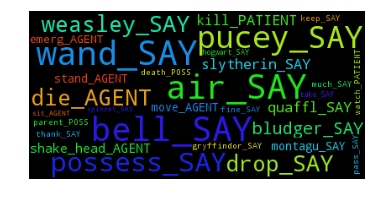

12
Topic  13
camera_POSS take_SAY hit_PATIENT laugh_AGENT stop_SAY happen_SAY quidditch_SAY home_SAY sped_AGENT watch_SAY call_PATIENT dodg_PATIENT pictur_SAY amaz_SAY offic_POSS year_SAY doe_SAY magic_SAY sit_AGENT anyth_SAY pleas_SAY might_SAY bit_SAY even_SAY follow_PATIENT hogwart_SAY wait_AGENT mind_SAY began_AGENT befor_SAY 


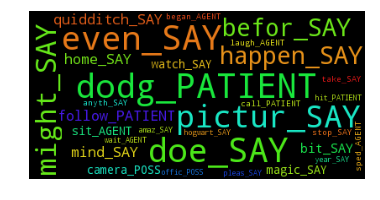

13
Topic  14
daddi_SAY scream_AGENT pull_PATIENT father_POSS snap_AGENT snorkack_SAY rope_POSS drag_PATIENT take_PATIENT start_AGENT friend_SAY year_SAY ani_SAY find_SAY hurri_AGENT believ_SAY hat_POSS escap_SAY horn_SAY crumple-horn_SAY turn_ey_AGENT armi_SAY help_AGENT four_SAY support_SAY took_PATIENT enter_AGENT take__AGENT ran_AGENT best_SAY 


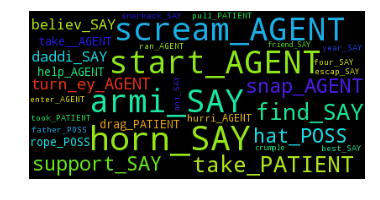

14
Topic  15
friend_POSS mother_POSS father_POSS cloak_POSS drop_SAY hold_PATIENT hear_AGENT roar_AGENT disappear_AGENT wait_AGENT pocket_POSS stand_SAY die_AGENT see_basilisk_AGENT let_slip_AGENT invis_SAY be_that_AGENT brother_POSS take_AGENT snog_SAY son_POSS betray_PATIENT call_snak_AGENT asid_SAY wake_SAY jerk_wand_AGENT petrifi_MOD catch_sight_AGENT girl_SAY loath_PATIENT 


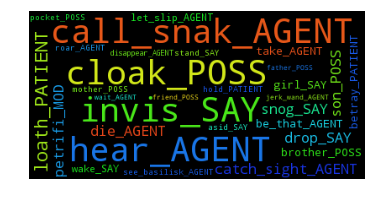

15
Topic  16
rasp_PATIENT snarl_PATIENT growl_PATIENT mudblood_SAY except_SAY attack__AGENT doe_SAY bit_SAY wonder_AGENT name_SAY weasley_SAY take_PATIENT met_PATIENT reckon_SAY roar_AGENT grin_AGENT girl_SAY see_it_AGENT roar_PATIENT lucius_SAY finish_SAY chang_SAY check_SAY involv_PATIENT known_SAY wheel_AGENT forc_AGENT seize__AGENT snarl_AGENT bring_PATIENT 


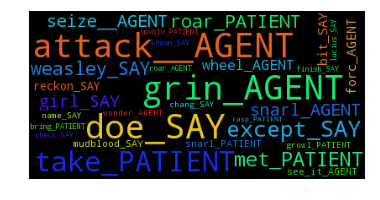

16
Topic  17
left_AGENT team_POSS quidditch_SAY tell_i_AGENT say_what_AGENT talk_POSS win_SAY wood_SAY dad_SAY even_SAY need_SAY last_SAY follow_PATIENT word_POSS sit_AGENT care_SAY team_SAY boy_SAY scar_POSS bed_POSS tell_they_AGENT believ_SAY firebolt_SAY seeker_SAY do_kind_AGENT took_AGENT decid_AGENT stand_SAY father_POSS take_PATIENT 


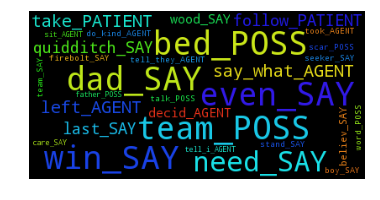

17
Topic  18
left_PATIENT dark_SAY leav_PATIENT wizard_SAY glass_POSS work_AGENT move_AGENT ad_AGENT watch_POSS molli_SAY idea_SAY happen_SAY son_SAY lord_SAY attack_PATIENT name_SAY shriek_PATIENT pant_AGENT scream_AGENT doe_SAY hous_POSS dare_SAY ministri_SAY glanc_AGENT pocket_POSS much_SAY muggl_SAY wife_POSS appear_AGENT fire_SAY 


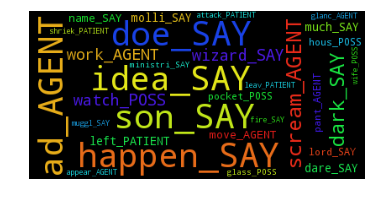

18
Topic  19
offic_POSS desk_POSS lord_SAY memori_POSS dark_SAY snape_SAY severus_SAY lip_POSS trust_PATIENT potion_SAY stop_AGENT death_SAY even_SAY move_AGENT offic_SAY need_SAY father_SAY draco_SAY mind_SAY save_SAY cloak_POSS find_SAY give_SAY do_what_AGENT onli_SAY dungeon_POSS essay_POSS friend_SAY idea_SAY work_SAY 


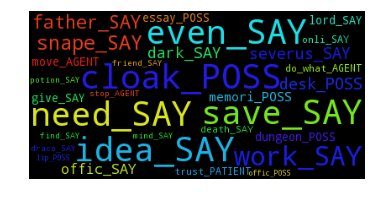

19
Topic  20
sure_MOD heart_POSS mind_POSS scar_POSS feel_AGENT stomach_POSS glanc_AGENT wonder_AGENT realiz_AGENT found_AGENT bed_POSS forehead_POSS notic_AGENT trunk_POSS ask__AGENT move_AGENT chest_POSS glass_POSS life_POSS er_SAY start_AGENT knee_POSS rememb_AGENT dobbi_SAY throat_POSS sir_SAY watch_AGENT onli_SAY watch_PATIENT way_POSS 


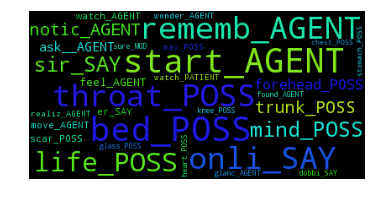

20
Topic  21
yeh_SAY yeh_SAY ter_SAY cabin_POSS o_SAY fer_SAY name_POSS do_what_AGENT jus_SAY stand_AGENT mind_POSS father_POSS move_AGENT weasley_SAY hogwart_SAY yer_SAY door_POSS return_AGENT support_POSS tom_SAY diari_POSS tha_SAY mother_POSS em_SAY kill_SAY littl_SAY magic_SAY soul_POSS bit_SAY last_SAY wizard_SAY 


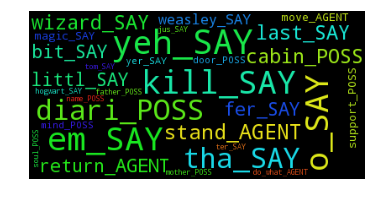

21
Topic  22
offic_POSS offic_POSS clipboard_POSS clipboard_POSS hem_SAY stand_AGENT room_POSS door_POSS high_SAY class_POSS classroom_POSS desk_POSS tell_i_AGENT inquisitor_SAY smile_POSS ought_SAY make_not_AGENT handbag_POSS teacher_SAY detent_SAY minist_SAY magic_SAY sign_SAY continu_AGENT minerva_SAY class_SAY today_SAY howev_SAY memori_POSS squeak_PATIENT predict_POSS dismiss_SAY 


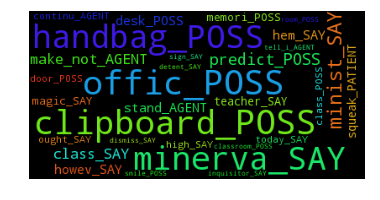

22
Topic  23
growl_PATIENT growl_PATIENT growl_AGENT cloak_POSS flask_POSS offic_POSS say_what_AGENT curs_SAY need_SAY death_SAY dark_SAY answer_AGENT desk_POSS grunt_PATIENT control_SAY crouch_SAY stop_PATIENT help_SAY roar_PATIENT might_SAY three_SAY raise_wand_AGENT hello_SAY year_SAY magic_SAY turn_SAY eater_SAY kill_SAY name_SAY lord_SAY glanc_AGENT 


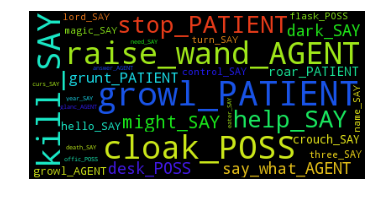

23
Topic  24
hagrid_SAY left_AGENT letter_POSS do_it_AGENT snitch_SAY hug_good-by_AGENT horntail_SAY ad_AGENT onli_SAY watch_PATIENT hurri_AGENT first_SAY mother_POSS okay_SAY call_AGENT gone_AGENT dad_SAY laugh_AGENT talk_AGENT help_PATIENT point_AGENT decid_AGENT friend_POSS lot_SAY gaze_AGENT broom_POSS arriv_AGENT alreadi_SAY hope_SAY sprint_AGENT 


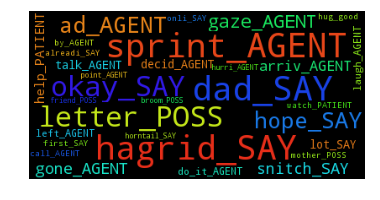

24


In [9]:
from wordcloud import WordCloud

from matplotlib.backends.backend_pdf import PdfPages
#pp = PdfPages('topics.pdf')

%matplotlib inline
top_texts = []
for i in range(0, numtopics):
    print 'Topic ', i
    text = ""
    word_tups = lda.show_topic(i, 30)
    for tup in word_tups:
        scale = (int)(tup[0]*100 + 1)
        for j in range(scale):
            text += (tup[1])
            text += " "
    print text
    img = WordCloud(max_font_size=40, relative_scaling=.1).generate(text)
    # Display the generated image:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    if not os.path.exists("topics"):
        os.makedirs("topics")
    print str(i)
    name = 'Topic '+str(i)+'.png'
    img.to_file("topics//"+name)
#pp.close()

#### Create topic matrix (dimensions num_characters x num_topics) containing topic probabilities for each character

In [10]:
topic_matrix = [[0 for i in range(numtopics)] for namekey in names]
print len(topic_matrix)
i = 0
for namekey in names:
    print i, str(namekey) + " topic distribution: "
    for (key, value) in lda[corpus[names[namekey]]]:
        topic_matrix[i][key] = value
    i+=1
    print lda[corpus[names[namekey]]]

109
0 Fang topic distribution: 
[(6, 0.99244094488147805)]
1 Lupin topic distribution: 
[(8, 0.7934289285236118), (19, 0.19749497820558157)]
2 Dudley topic distribution: 
[(9, 0.99821892393312883)]
3 Cho topic distribution: 
[(4, 0.99499999999965916)]
4 Bertha Jorkins topic distribution: 
[(22, 0.98545454545099953)]
5 Fred topic distribution: 
[(0, 0.034526205192785403), (3, 0.90884416589800077), (17, 0.042870436245069109)]
6 Hogwarts topic distribution: 
[(18, 0.99577092510995768)]
7 Pansy Parkinson topic distribution: 
[(1, 0.98719999999811914)]
8 Kingsley topic distribution: 
[(18, 0.98814814814759677)]
9 Moody topic distribution: 
[(23, 0.99642734197786165)]
10 Winky topic distribution: 
[(19, 0.9947826086952799)]
11 James topic distribution: 
[(15, 0.99559633027502381)]
12 Voldemort topic distribution: 
[(8, 0.2099779291374764), (20, 0.040324135182479424), (21, 0.74658190387409185)]
13 Crookshanks topic distribution: 
[(7, 0.97658536585299083)]
14 Bellatrix topic distribution: 
[(

#### Bar plot visualization of above character topic probabilities

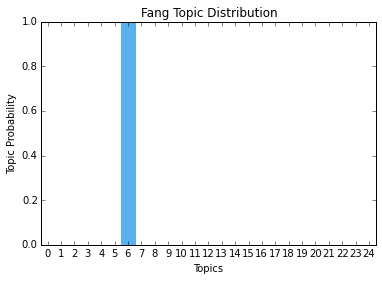

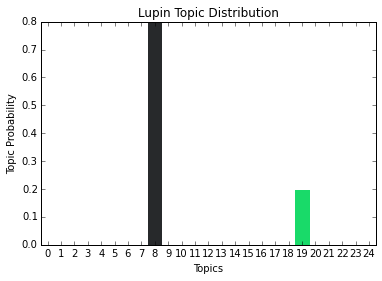

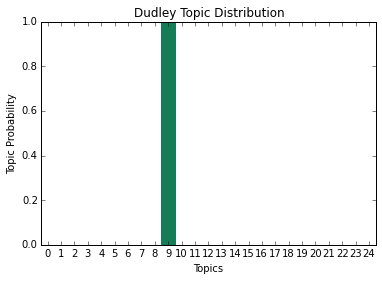

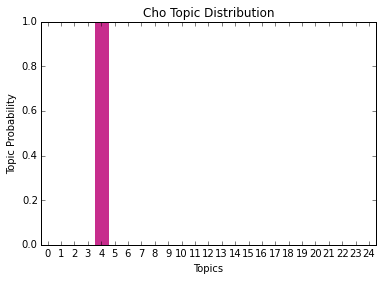

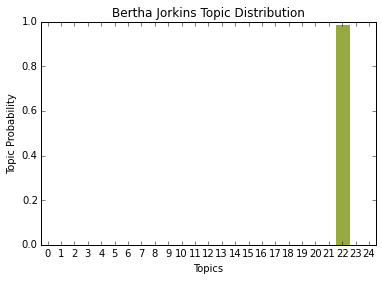

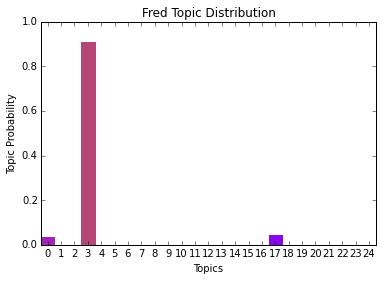

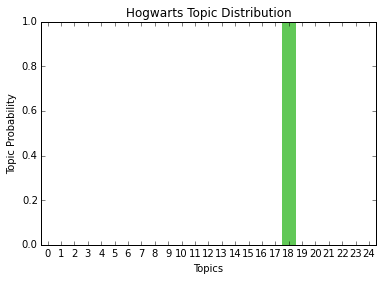

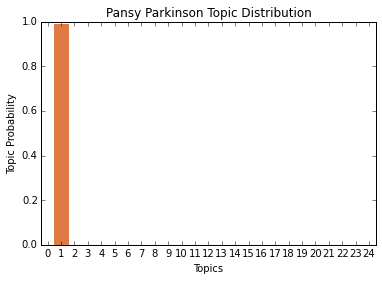

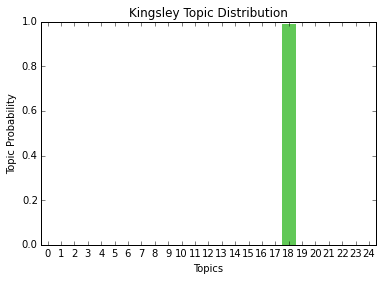

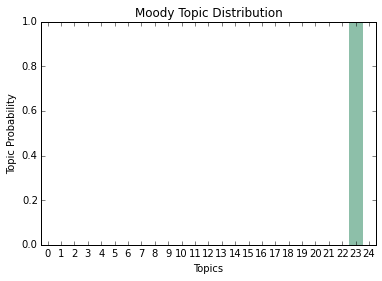

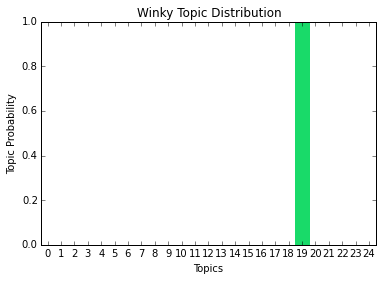

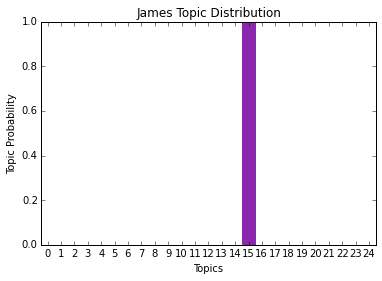

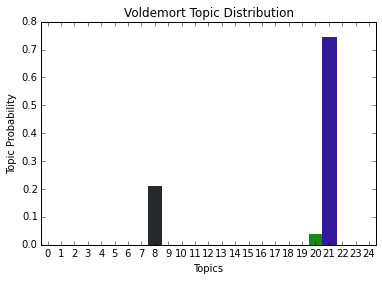

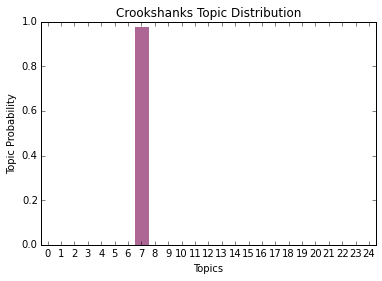

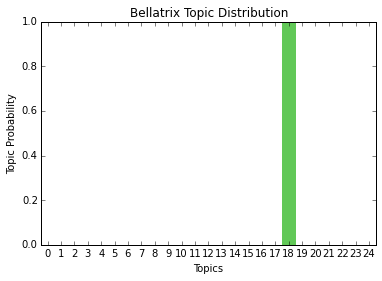

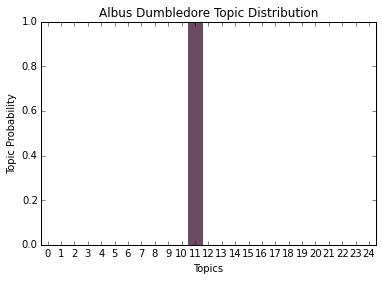

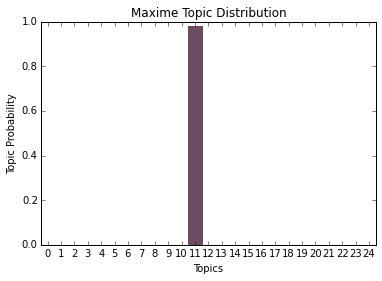

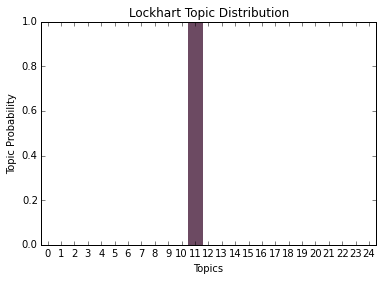

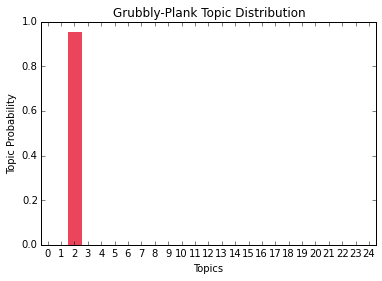

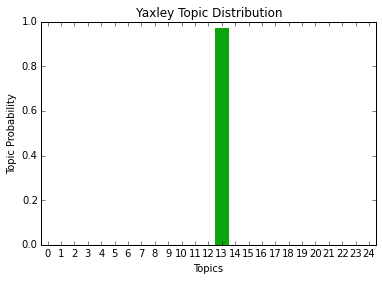

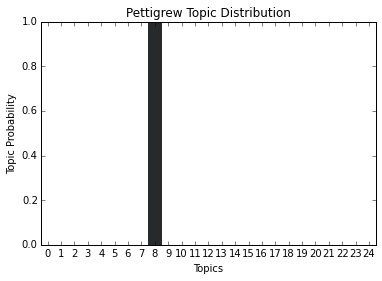

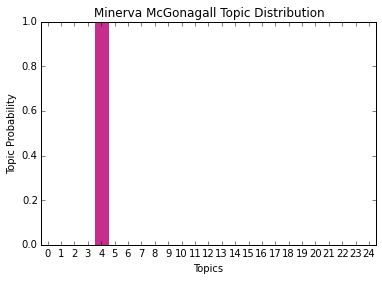

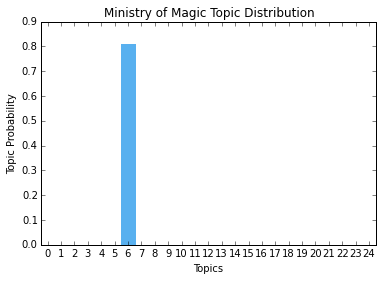

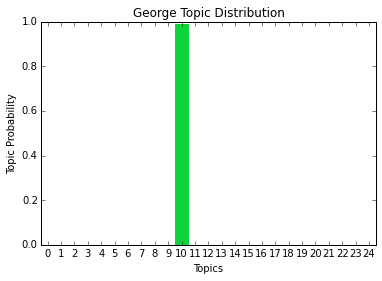

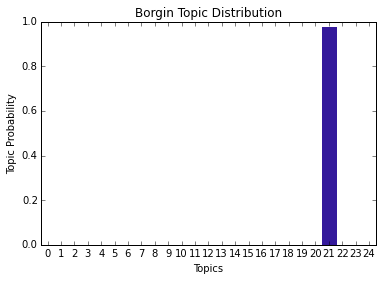

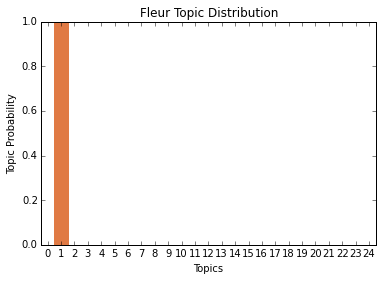

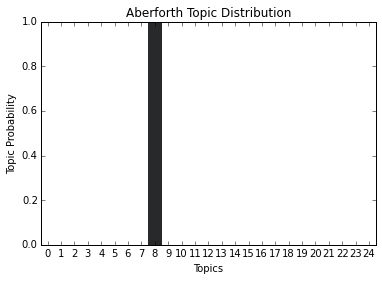

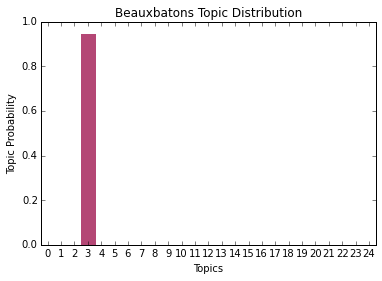

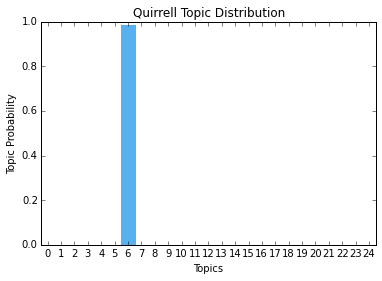

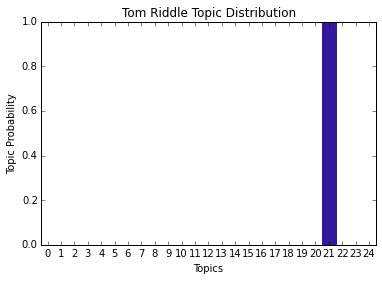

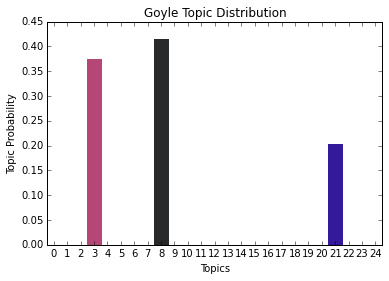

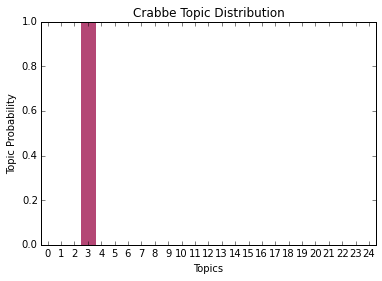

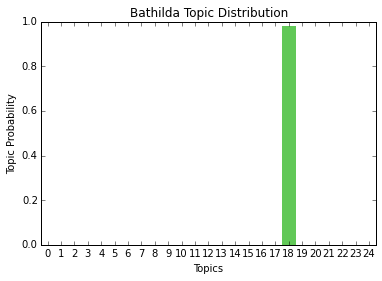

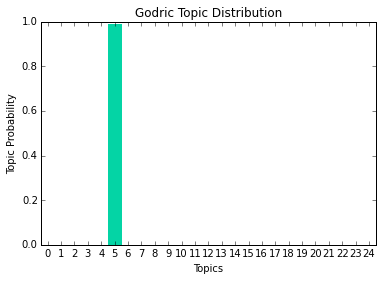

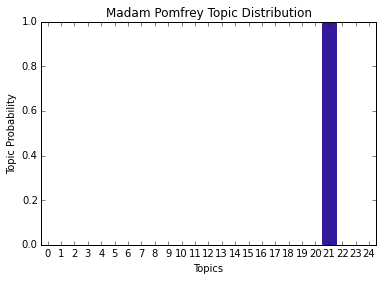

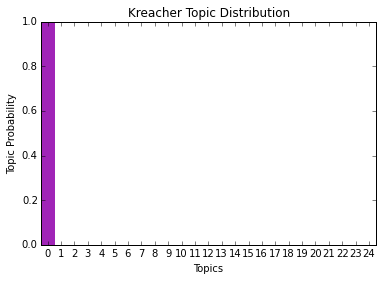

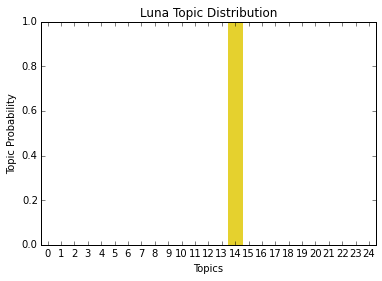

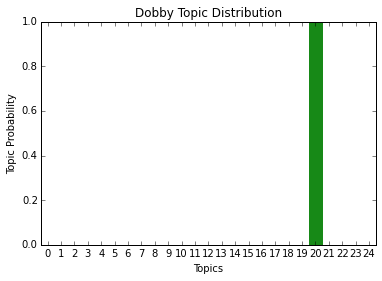

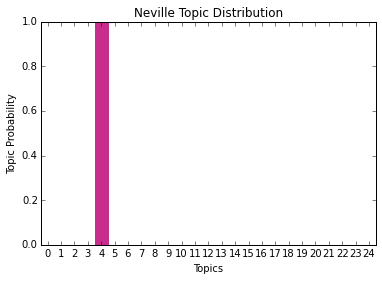

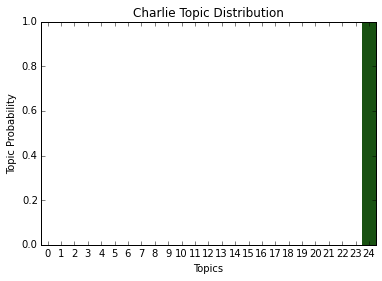

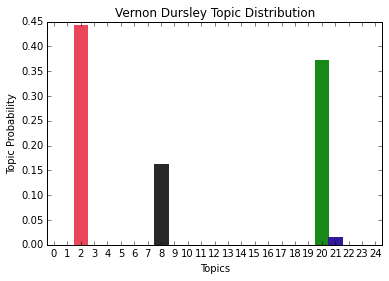

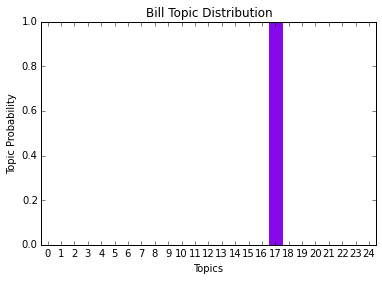

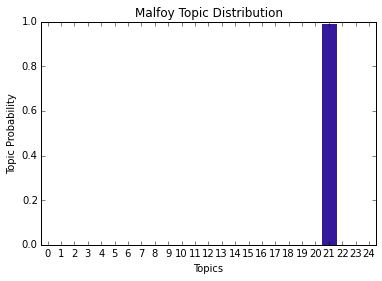

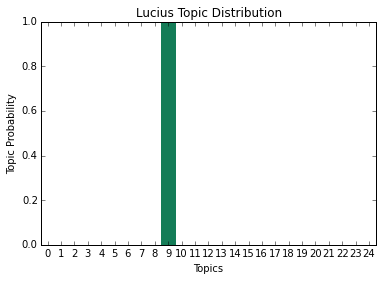

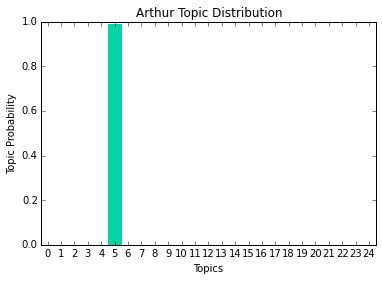

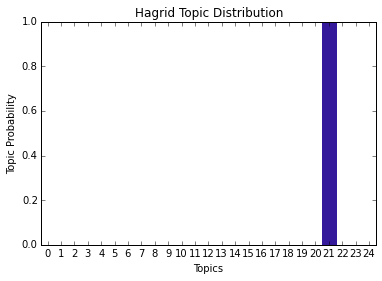

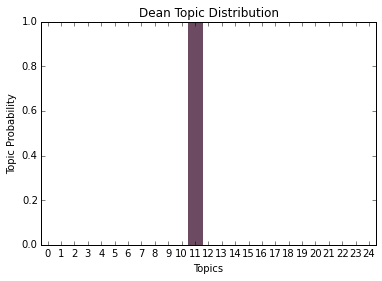

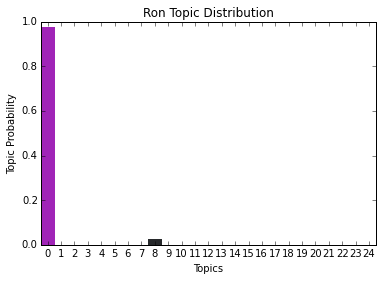

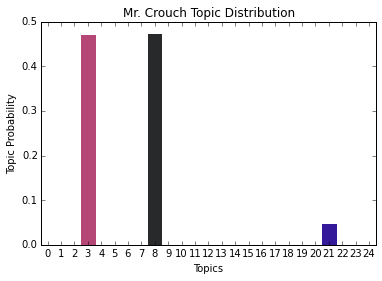

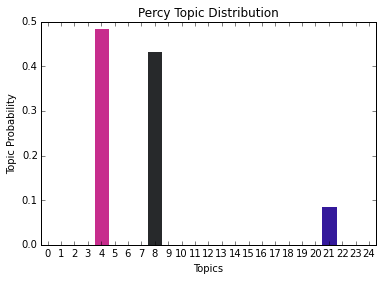

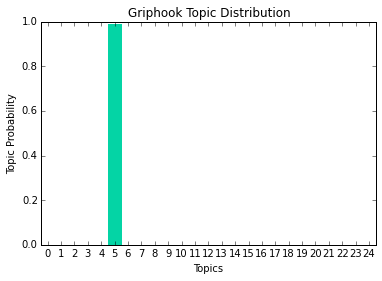

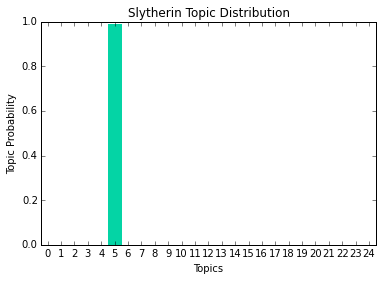

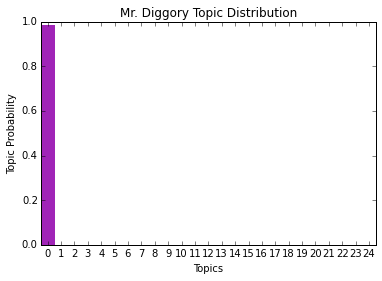

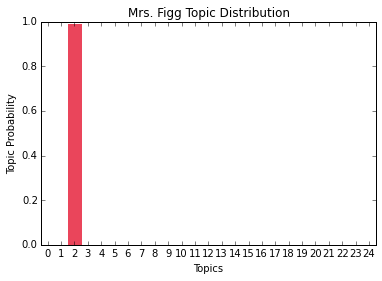

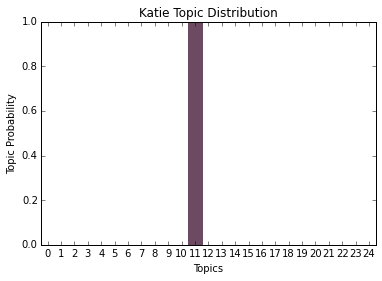

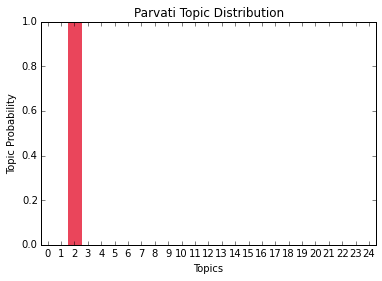

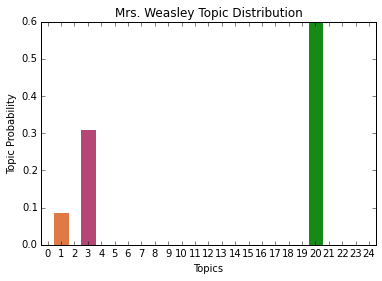

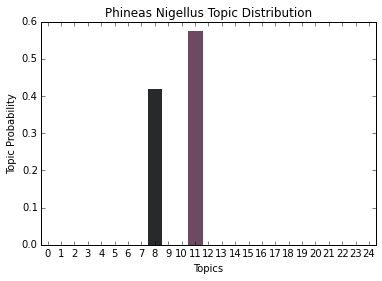

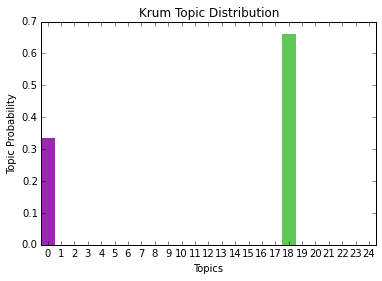

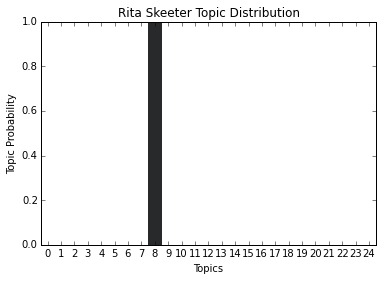

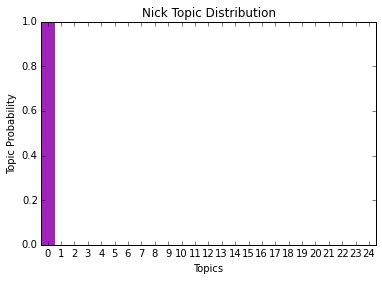

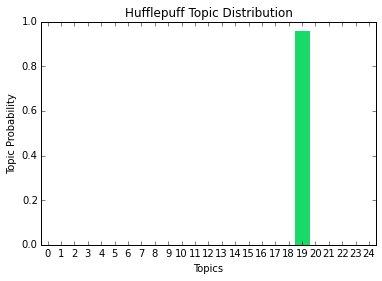

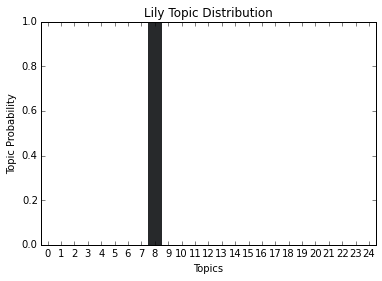

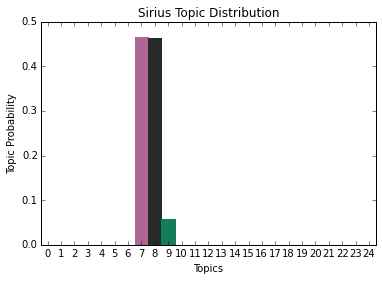

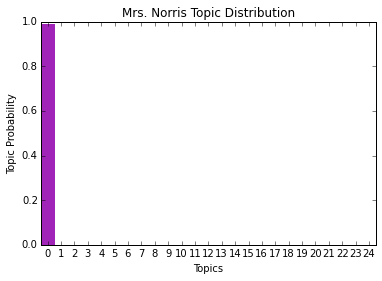

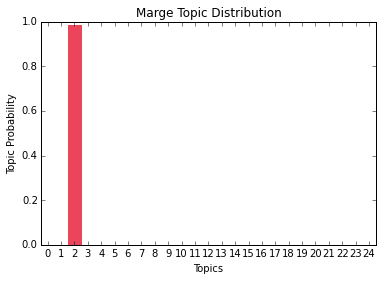

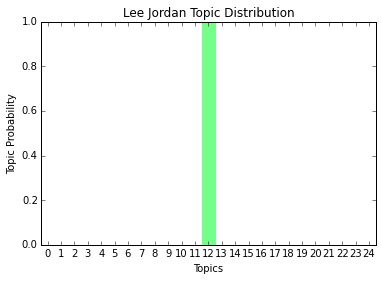

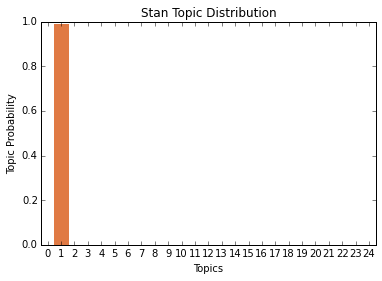

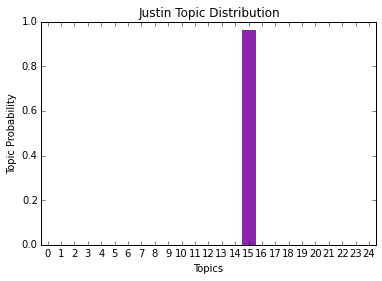

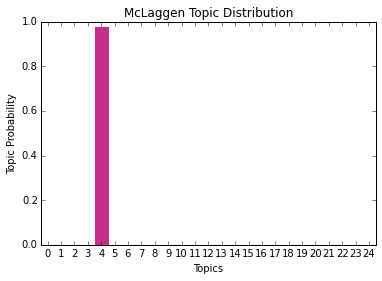

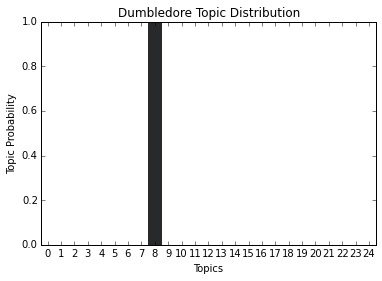

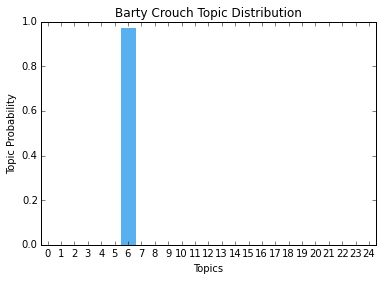

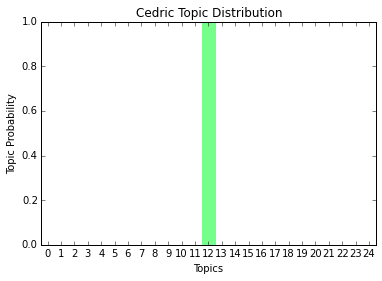

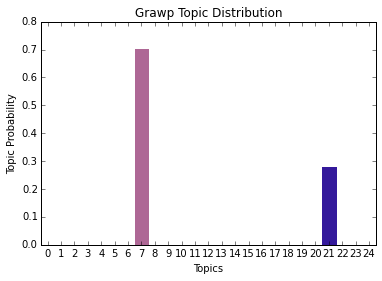

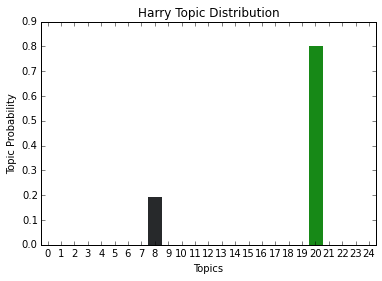

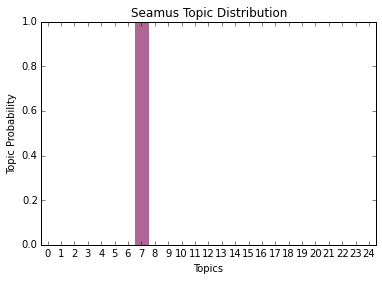

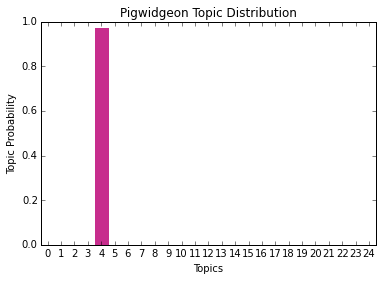

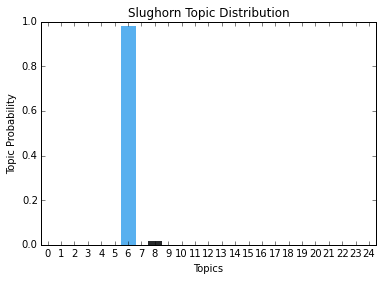

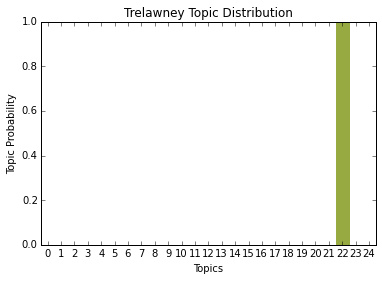

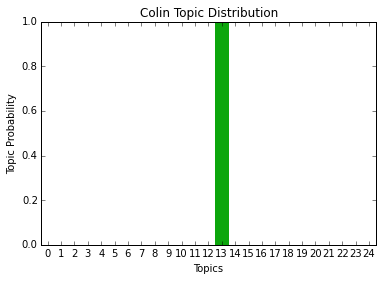

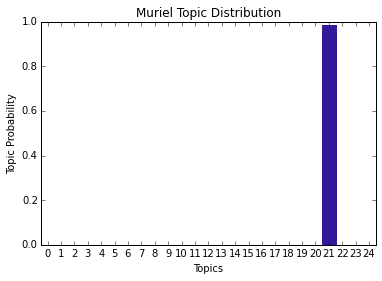

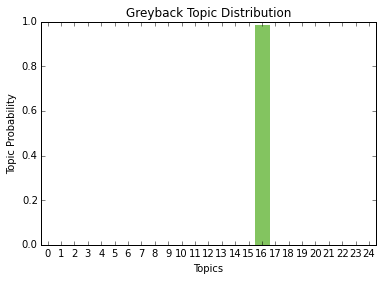

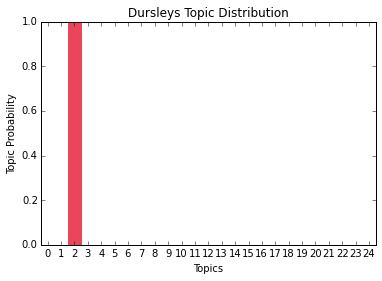

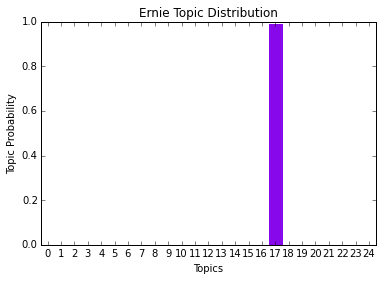

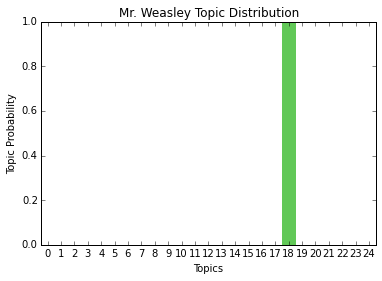

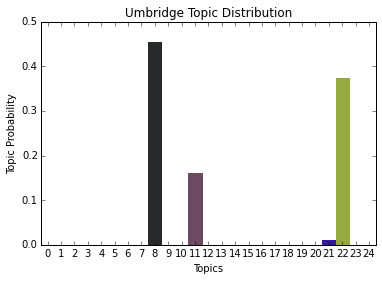

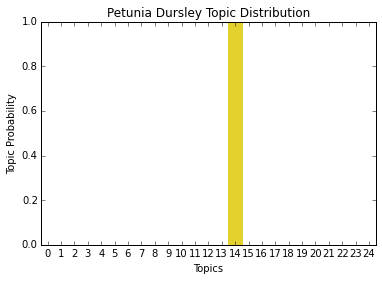

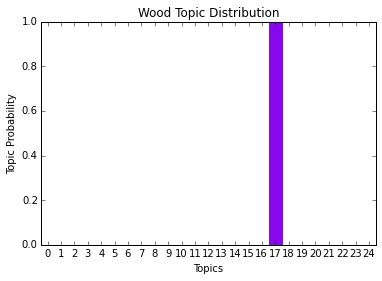

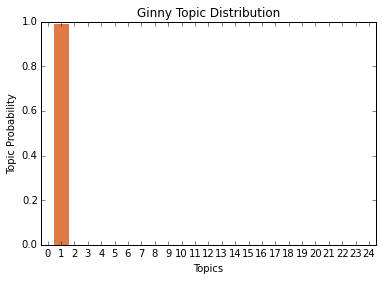

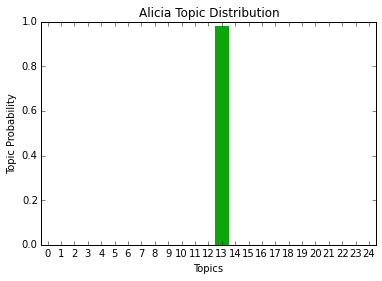

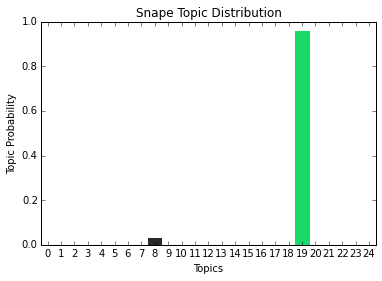

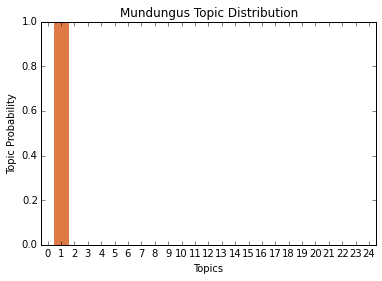

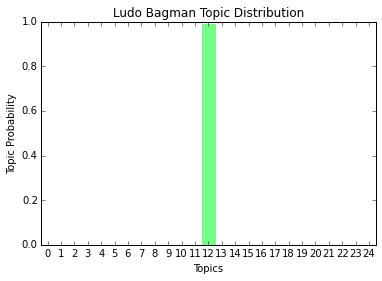

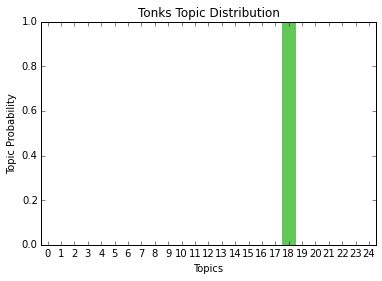

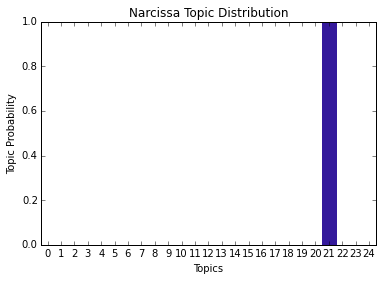

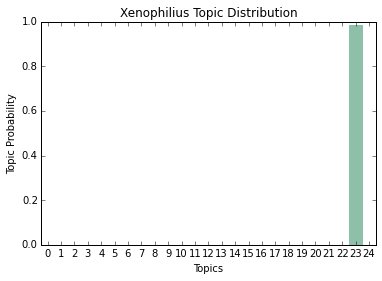

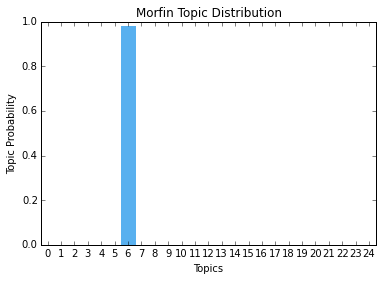

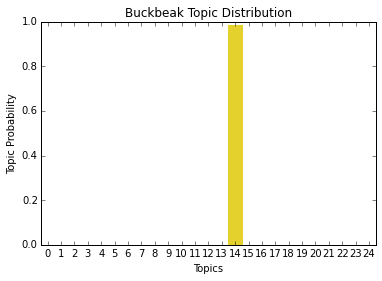

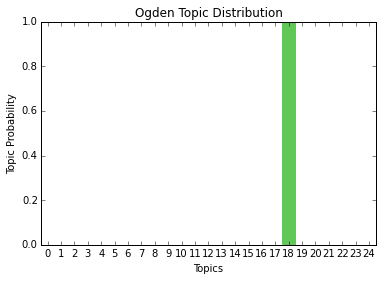

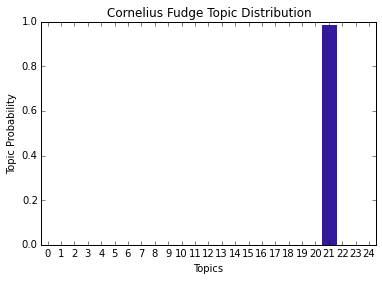

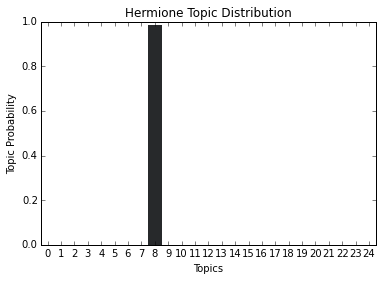

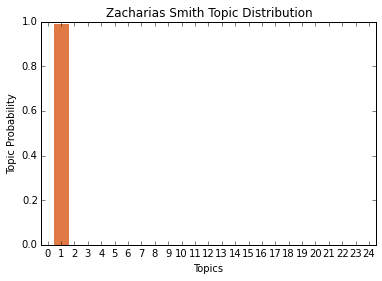

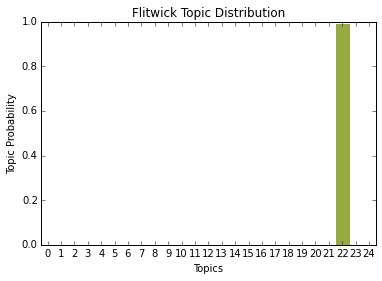

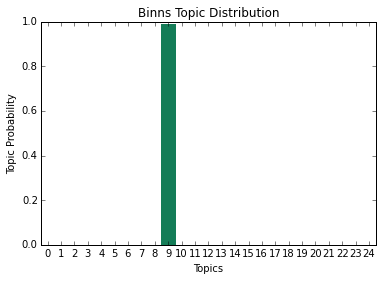

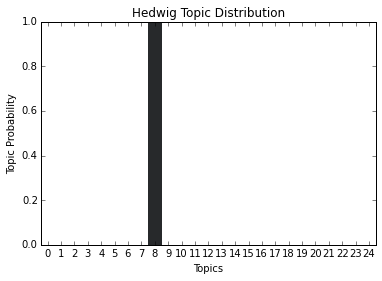

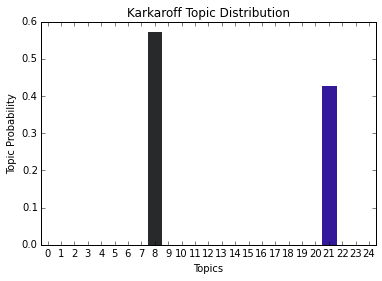

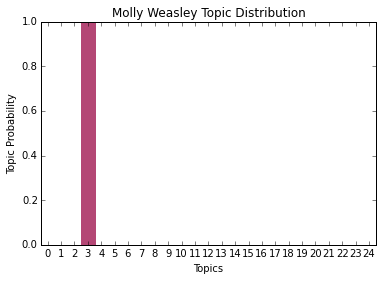

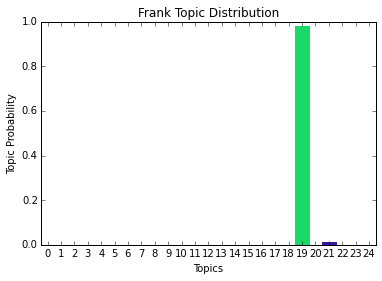

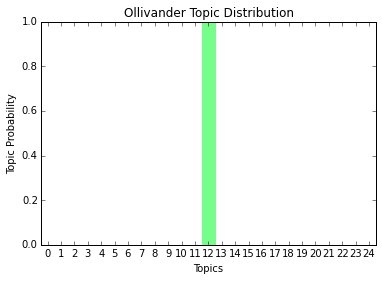

In [11]:
# Plot bar charts for each character's topics

# choose some random colors to represent each topic
topicColors = []
for i in range(numtopics):
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    topicColors.append(color)

%matplotlib inline 

if not os.path.exists("char_topic_charts"):
    os.makedirs("char_topic_charts")

# iterate through the character topic vectors, making a plot for each
nameit = names.iterkeys()
for charArray in topic_matrix:
    ind = np.arange(len(charArray))  # the x locations for the topics
    fig, ax = plt.subplots()
    width = 1
    
    topicNames = []
    topicProbs = []
    for i in range(len(charArray)):
        topicNames.append(i)
    
    rects1 = ax.bar(ind, charArray, width)
    for i in range(len(charArray)):
        rects1[i].set_color(topicColors[topicNames[i]])
        
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Topic Probability')
    ax.set_xlabel('Topics')
    title =  nameit.next() + ' Topic Distribution'
    ax.set_title(title)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(topicNames)
    plt.show()
    plt.savefig("char_topic_charts//"+title+".png")


## Perform Clustering Based on Character Topic Vectors

The following code is heavily derivative of Brandon Rose's tutorial on topic modeling and clustering. 
http://brandonrose.org/clustering

#### Use KMeans (is this the best choice?) and print out the clusters list

In [12]:
data = np.array(topic_matrix)

from sklearn.cluster import KMeans
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data)
clusters = kmeans.labels_.tolist()
print clusters
# "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters."
goodness = metrics.silhouette_score(data, kmeans.labels_, metric='euclidean')
print "silhouette score: " + str(goodness)
# within-cluster sum of squares
print "inertia: " + str(kmeans.inertia_)

[12, 3, 8, 9, 8, 13, 0, 5, 0, 8, 11, 8, 2, 8, 0, 1, 1, 1, 6, 8, 3, 9, 12, 8, 2, 5, 3, 13, 12, 2, 3, 13, 0, 10, 2, 4, 8, 8, 9, 8, 8, 14, 2, 8, 10, 2, 1, 4, 13, 9, 10, 10, 4, 6, 1, 6, 8, 1, 0, 3, 4, 11, 3, 3, 4, 6, 7, 5, 8, 9, 3, 12, 7, 8, 8, 8, 9, 12, 8, 8, 2, 8, 6, 14, 0, 3, 8, 14, 5, 8, 11, 5, 7, 0, 2, 8, 12, 8, 0, 2, 3, 5, 8, 8, 3, 3, 13, 11, 7]
silhouette score: 0.649937193684
inertia: 23.9976151482


#### Print out characters and cluster assignments (in order)

In [13]:
dic={}
i=0
for nameKey in names:
    dic[str(nameKey)]=clusters[i]
    i += 1
d=sorted(dic.items(), key=lambda x:x[1])
for name in d:
    print name

('Hogwarts', 0)
('Kingsley', 0)
('Bellatrix', 0)
('Bathilda', 0)
('Krum', 0)
('Mr. Weasley', 0)
('Tonks', 0)
('Ogden', 0)
('Albus Dumbledore', 1)
('Maxime', 1)
('Lockhart', 1)
('Dean', 1)
('Katie', 1)
('Phineas Nigellus', 1)
('Voldemort', 2)
('Tom Riddle', 2)
('Madam Pomfrey', 2)
('Malfoy', 2)
('Hagrid', 2)
('Borgin', 2)
('Muriel', 2)
('Narcissa', 2)
('Cornelius Fudge', 2)
('Lupin', 3)
('Karkaroff', 3)
('Pettigrew', 3)
('Aberforth', 3)
('Goyle', 3)
('Rita Skeeter', 3)
('Lily', 3)
('Sirius', 3)
('Dumbledore', 3)
('Umbridge', 3)
('Hermione', 3)
('Hedwig', 3)
('Mr. Diggory', 4)
('Kreacher', 4)
('Nick', 4)
('Mrs. Norris', 4)
('Ron', 4)
('Pansy Parkinson', 5)
('Fleur', 5)
('Stan', 5)
('Ginny', 5)
('Mundungus', 5)
('Zacharias Smith', 5)
('Grubbly-Plank', 6)
('Mrs. Figg', 6)
('Parvati', 6)
('Marge', 6)
('Dursleys', 6)
('Lee Jordan', 7)
('Cedric', 7)
('Ludo Bagman', 7)
('Ollivander', 7)
('Dudley', 8)
('Bertha Jorkins', 8)
('Moody', 8)
('James', 8)
('Crookshanks', 8)
('Yaxley', 8)
('George', 8)

#### Create data frame for clusters and characters

In [14]:
tempNameList = [nameKey for nameKey in names]
charClusts = {'characters': tempNameList, 'clusters': clusters}
frame = pd.DataFrame(charClusts, index = [clusters] , columns = ['character', 'clusters'])

In [15]:
frame['clusters'].value_counts() 

8     26
3     12
2      9
0      8
12     6
9      6
5      6
1      6
13     5
6      5
4      5
11     4
10     4
7      4
14     3
Name: clusters, dtype: int64

#### Show visual cluster plot 

In [16]:
# get euclidean distance between each character's topic vector
dist = euclidean_distances(data, data)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
    
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=tempNameList)) 

#group by cluster
groups = df.groupby('label')

In [17]:
# assign cluster colors and names
cluster_colors = defaultdict(None)
cluster_names = defaultdict(None)
# randomly generate n colors based on the number of clusters desired
for i in range(len(clusters)):
    import random
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    cluster_colors[i] = color
    cluster_names[i] = i

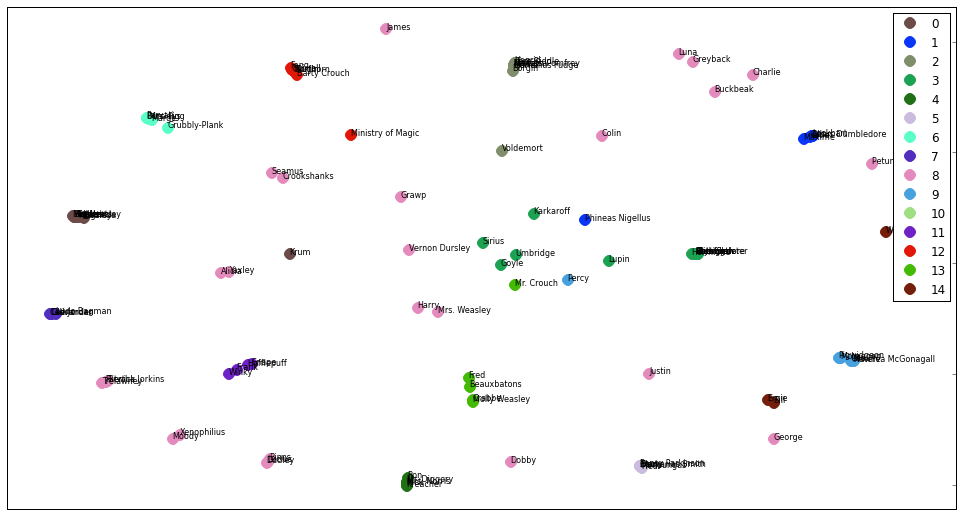

In [18]:
#The following is taken word for word from this tutorial: http://brandonrose.org/clustering

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  



plt.show() #show the plot


In [19]:
#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)
plt.close()

#### Create and show dendrogram for the characters 

Again, taken almost verbatim from Brandon Rose's tutorial, implementation credit goes to him

C:\Users\Molly\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


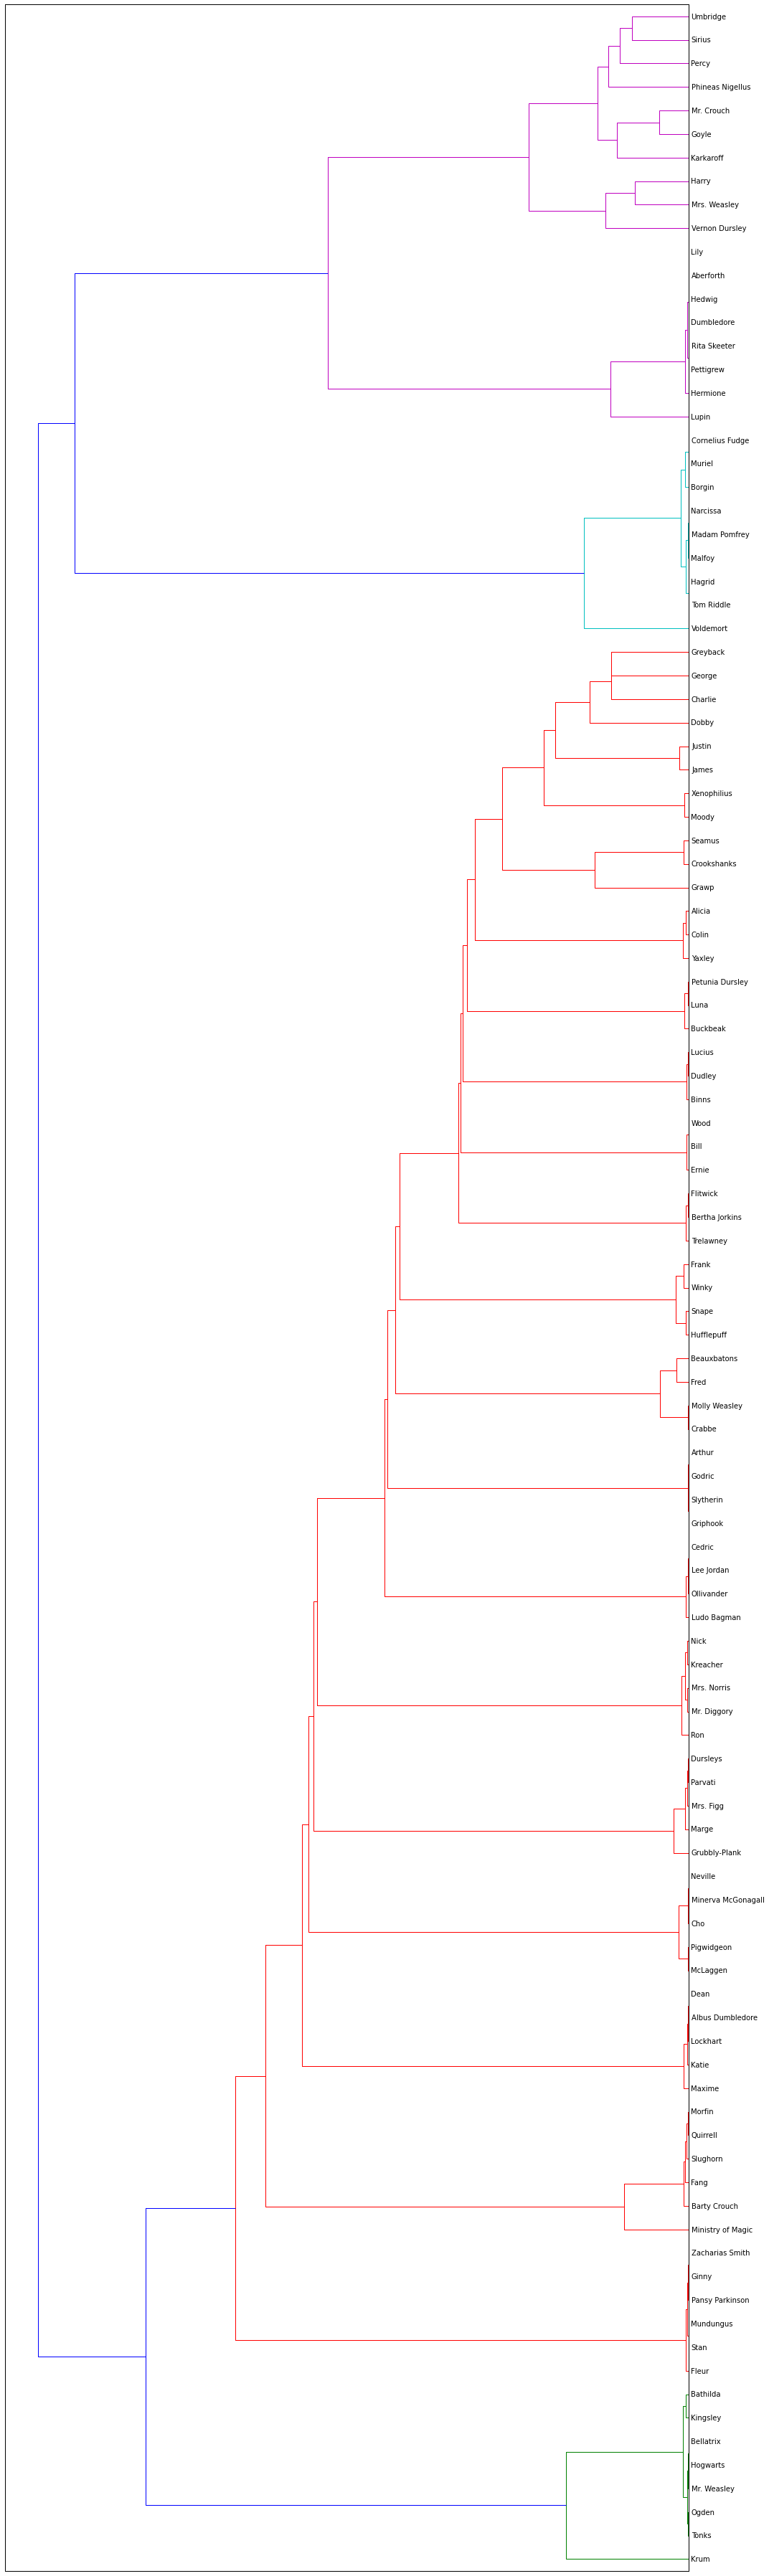

In [20]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 50)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=charClusts['characters']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Supervised Learning with Topics

 What follows is an attempt to use the characters' generated topic probabilities as features for supervised learning (specifically logistic regression). Based on our ground truth labeled information, we will see whether the topic assignments are informative/useful for predicting these labels or not.

In [21]:
# load our labeled character data (choose one of our annotated character files)
import getVectors
getVectors = reload(getVectors)
# labels = ['Muggles', 'Hogwarts Students', 'Hogwarts Teachers', 'Ministry Officials', 
#           'Quidditch Players', 'Gryffindors', 'Ravenclaws', 'Hufflepuffs','Slytherins',
#          'Muggle-borns','Purebloods','Half-bloods','Humans','Part Humans', 'Non-Humans',
#          'Death Eaters', 'Order of the Phoenix', 'Dumbledores Army','Animagi', 'Parselmouths',
#          'Convicts','Weasleys','Dead','Bullies', 'Victims']
#(vectors, charlist) = getVectors.getVectors("cluster.txt")
labels = ['Protagonists', 'Antagonists', 'Neutral', 'Animals']
(vectors, charlist) = getVectors.getVectors("good_bad_labels.txt")
print charlist

['Lupin', 'Cho', 'Albus Dumbledore', 'Lily', 'Cedric', 'Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Fred Weasley', 'George Weasley', 'Neville Longbottom', 'Ginny Weasley', 'Luna Lovegood', 'Dean Thomas', 'Oliver Wood', 'Rubeus Hagrid', 'Minerva McGonagall', 'Mad-Eye Moody', 'Arthur Weasley', 'Mr. Weasley', 'Tonks', 'Kingsley Shacklebolt', 'Viktor Krum', 'Sirius Black', 'Bill', 'Godric Gryffindor', 'Mrs. Weasley', 'Regulus', 'Fleur Delacour', 'Dobby', 'James Potter', 'Dudley', 'Malfoys', 'Yaxley', 'Goyle', 'Phineus Nigelus', 'Quirrell', 'Mr. Dursley', 'Mrs. Dursley', 'Aunt Marge', 'Draco Malfoy', 'Crabbe', 'Pansy Parkinson', 'Zacharias Smith', 'Montague', 'Severus Snape', 'Dolores Umbridge', 'Lucius', 'Cornelius Fudge', 'Barty Crouch', 'Peter Pettigrew', 'Voldemort', 'Bellatrix Lestrange', 'Salazar Slytherin', 'Narcissa Malfoy', 'Morfin', 'Antonin Dolohov', 'Rita Skeeter', 'Igor Karkaroff', 'Filch', 'Macnair', 'Travers', 'Fenrir Greyback', 'Kreacher', 'Griphook', 'Madam Hooch', '

In [22]:
# shuffle our samples
# combined = zip(charlist, vectors)
# random.shuffle(combined)
# charlist[:], vectors[:] = zip(*combined)

# just checking to make sure the vectors look right
# for i in range(len(vectors)):
#     print charlist[i]
#     print vectors[i]

In [23]:
# get a list of the indices for labeled characters that were recognized by book-nlp 
# (if they weren't returned in the character list, we can't classify them)
labeled = {}
j = 0 # index of character in labeled character list
for name in charlist:
    i = 0 # index of character in topic model vectors list
    found = False
    for name2 in names:
        #print name2
        if name.encode('UTF-8') in character_namelists[name2]:
            found = True
        elif not found == True:
            i+=1
    if found:
        # print name.encode('UTF-8')
        # tupe is topic vector index, charlist index
        labeled[name] = (j, i)
    #else:
        #print name.encode('UTF-8')
    j+=1
num_samples = len(labeled)
print num_samples

94


In [24]:
#print len(topic_matrix)
matrix = []
labeled_topic_matrix = []
labeled_chars = []
for char in labeled:
    #print char
    (charNameIndex, charTopicIndex) = labeled[char]
    print charNameIndex, charTopicIndex
    print charlist[charNameIndex]
    labeled_chars.append(charlist[charNameIndex])
    print vectors[charNameIndex]
    matrix.append(vectors[charNameIndex])
    print topic_matrix[charTopicIndex]              
    labeled_topic_matrix.append(topic_matrix[charTopicIndex])
    print

labeled_topic_matrix = np.array(labeled_topic_matrix) 
#print labeled_topic_matrix

labelmatrix = np.matrix(matrix)
#print labelmatrix

11 88
Ginny Weasley
[1, 0, 0, 0]
[0, 0.989891977187637, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

116 67
Stan Shunpike
[0, 0, 1, 0]
[0, 0.99111111111065187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

0 1
Lupin
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0.79343231341849918, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.19749491563374352, 0, 0, 0, 0, 0]

31 2
Dudley
[0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99821892393312883, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1 3
Cho
[1, 0, 0, 0]
[0, 0, 0, 0, 0.99499999999954791, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

18 44
Arthur Weasley
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0.98857142857104041, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

84 79
Colin Creevey
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99186440677917986, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

135 0
Fang
[0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0.99244094488148227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [25]:
from sklearn import linear_model
from sklearn import cross_validation


# choose the appropriate row to get your binary labels for feature i, then split it into a train/test set
# i.e. Muggles vs. not muggles, good guys vs. not good guys, etc.
for label in range(labelmatrix[0].size):
    print labels[label]
    #X_train, X_test, y_train, y_test = cross_validation.train_test_split(labeled_topic_matrix, labelmatrix[:,label], test_size=0.4, random_state=0)
    logreg = linear_model.LogisticRegression(C=1e5)
    # train
    #logreg.fit(X_train, y_train)
    #Z = logreg.predict(X_test)
    #print "accuracy: ", logreg.score(X_test, y_test)
    # print Z
    print "Accuracy:"
    accuracyScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2)
    print accuracyScores
    print "Precision:"
    precisionScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'precision')
    print precisionScores
    print "Recall:"
    recallScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'recall')
    print recallScores
    print

Protagonists
Accuracy:
[ 0.65957447  0.63829787]
Precision:
[ 0.42857143  0.4       ]
Recall:
[ 0.2         0.26666667]

Antagonists
Accuracy:
[ 0.66666667  0.67391304]
Precision:
[ 0.28571429  0.2       ]
Recall:
[ 0.15384615  0.08333333]

Neutral
Accuracy:
[ 0.65957447  0.57446809]
Precision:
[ 0.5         0.41666667]
Recall:
[ 0.5625  0.625 ]

Animals
Accuracy:
[ 0.83333333  0.60869565]
Precision:
[ 0.  0.]
Recall:
[ 0.  0.]

